# World Bank Ethiopia Capstone Project

## Stage 4: Dashboard, Reporting, and Advanced Analysis

### Project Overview
This notebook performs comprehensive dashboard creation, advanced analysis, and reporting for the World Bank Ethiopia macroeconomic analysis project. It includes trendline calculations, cross-correlation analysis, policy insights, and machine learning forecasting.

### Objectives
1. **Data Loading**: Load cleaned dataset with proper datetime indexing
2. **Visualization Dashboard**: Create comprehensive visualizations of all indicators
3. **Trendline Analysis**: Calculate and visualize trendlines for key indicators
4. **Cross-Correlation Analysis**: Examine lead-lag relationships between indicators
5. **ARIMA Forecasting Dashboard**: Generate future forecasts using ARIMA models
6. **Machine Learning Forecasting**: Implement ML models (Linear Regression, Random Forest, SVR, XGBoost)
7. **Policy Insights**: Generate actionable insights for policymakers
8. **Final Summary**: Compile comprehensive project summary

### Key Indicators Analyzed
- **GDP (constant 2015 US$)**: Total economic output
- **GDP growth (annual %)**: Economic growth rate
- **GDP per capita (constant 2015 US$)**: Economic output per person
- **Inflation, consumer prices (annual %)**: Price level changes
- **Unemployment, total (% of total labor force)**: Labor market conditions

### Data Source
- **Source**: World Bank Open Data
- **Dataset**: World Development Indicators (WDI)
- **Country**: Ethiopia (ETH)
- **Time Period**: 1960-2024
- **File**: `datasets/cleaned/ethiopia_analytic_dataset.csv`


In [ ]:
# ================================================
# STEP 1: IMPORT LIBRARIES AND LOAD DATA
# ================================================

# Import required libraries for data analysis, visualization, and forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for professional plots
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("=" * 80)
print("STAGE 4: DASHBOARD, REPORTING, AND ADVANCED ANALYSIS")
print("=" * 80)
print("\nLibraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# Load the cleaned dataset from Stage 1
# Note: The dataset should have Year as a column initially
df = pd.read_csv("../datasets/cleaned/ethiopia_analytic_dataset.csv", index_col=0)

# Restore the Year column (it was used as index during save)
df = df.reset_index().rename(columns={"index": "Year"})

# Convert Year to datetime for proper time series handling
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# Sort by year and set Year as index for time series operations
df = df.sort_values("Year").set_index("Year")

print(f"\n✓ Dataset loaded successfully!")
print(f"  - Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  - Year range: {df.index.min().year} to {df.index.max().year}")
print(f"  - Indicators: {', '.join(df.columns.tolist())}")

# Display first few rows
print("\n" + "=" * 80)
print("DATASET PREVIEW:")
print("=" * 80)
display(df.head())


,gdp_constant,gdp_growth,gdp_per_capita,inflation,unemployment
Year,,,,,
1961-01-01,5.263329e+09,NaN,240.267722,NaN,NaN
1962-01-01,5.491026e+09,4.326091,244.424432,NaN,NaN
1963-01-01,5.739145e+09,4.518634,248.969086,NaN,NaN
1964-01-01,5.973904e+09,4.090486,252.419740,NaN,NaN
1965-01-01,6.318714e+09,5.771932,259.915858,NaN,NaN


## Step 2: Comprehensive Visualization Dashboard

Create a comprehensive dashboard showing all economic indicators together. This provides a holistic view of Ethiopia's economic performance over time.


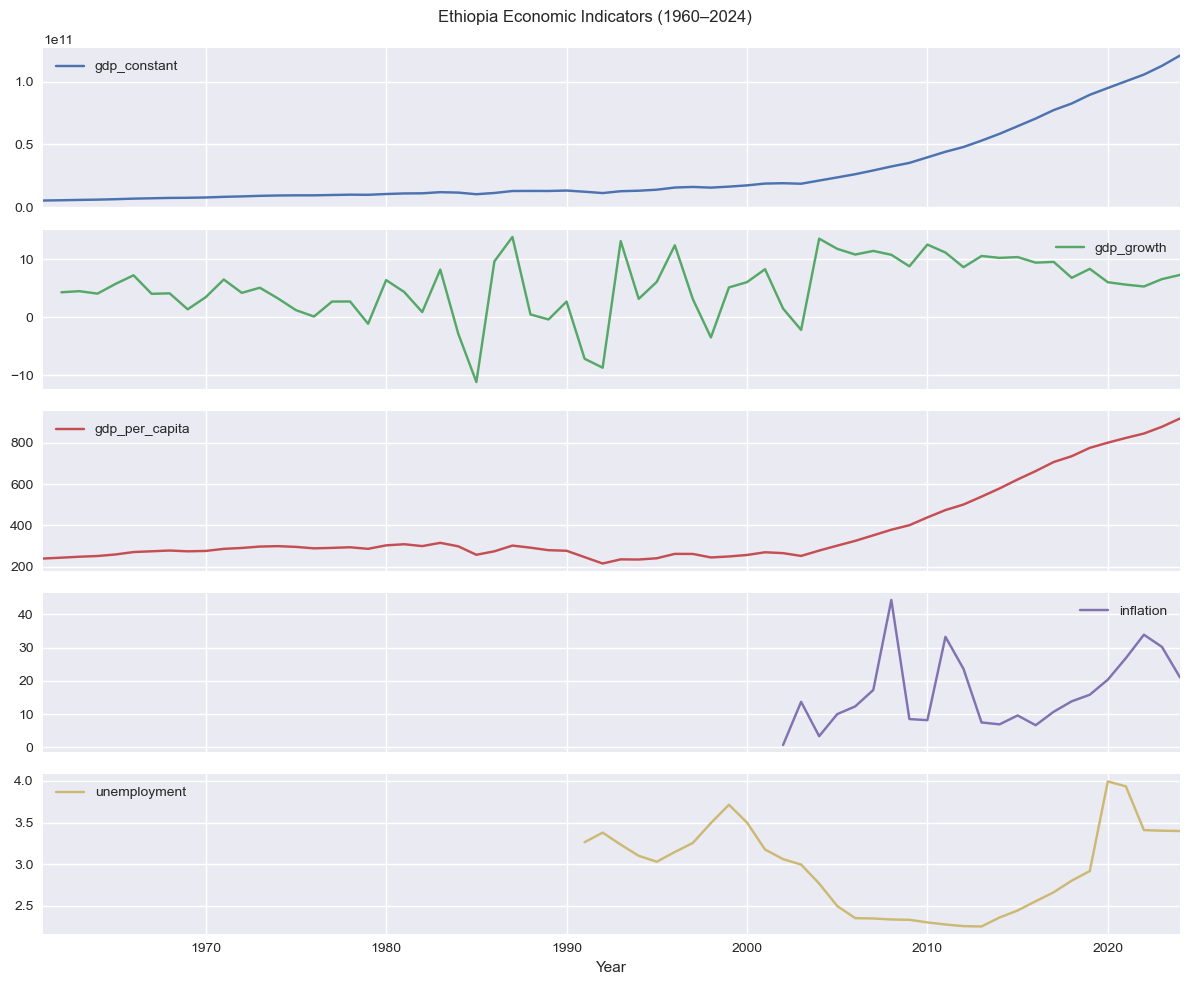

In [ ]:
# Create comprehensive subplot dashboard of all indicators
# This provides a holistic view of Ethiopia's economic performance
print("=" * 80)
print("COMPREHENSIVE VISUALIZATION DASHBOARD")
print("=" * 80)

# Create subplots for all indicators
fig, axes = plt.subplots(len(df.columns), 1, figsize=(14, 12))
fig.suptitle('Ethiopia Economic Indicators - Comprehensive Dashboard (1960-2024)', 
             fontsize=16, fontweight='bold', y=0.995)

# Define colors for each indicator
colors = ['#2E86AB', '#A23B72', '#06A77D', '#F18F01', '#C73E1D']

# Plot each indicator in its own subplot
for idx, (col, color) in enumerate(zip(df.columns, colors)):
    ax = axes[idx]
    data = df[col].dropna()
    
    if len(data) > 0:
        # Apply transformation for GDP constant (convert to billions)
        if col == 'gdp_constant':
            plot_data = data / 1e9
            ylabel = 'GDP (Billions USD)'
        else:
            plot_data = data
            ylabel = col.replace('_', ' ').title() + (' (%)' if col in ['gdp_growth', 'inflation', 'unemployment'] else '')
        
        ax.plot(data.index, plot_data, linewidth=2, color=color, label=col.replace('_', ' ').title())
        ax.set_title(col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print("\n✓ Dashboard visualization complete!")


## Step 3: Trendline Analysis

Calculate and visualize trendlines for key indicators to identify long-term patterns and growth trajectories. Trendlines help understand the overall direction and rate of change in economic indicators.


In [ ]:
# ================================================
# TRENDLINE CALCULATIONS
# ================================================
from scipy import stats

print("=" * 80)
print("TRENDLINE ANALYSIS")
print("=" * 80)

# Function to calculate and plot trendline
def calculate_trendline(series, indicator_name):
    """
    Calculate linear trendline for a time series and return slope, intercept, and R-squared.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data with datetime index
    indicator_name : str
        Name of the indicator for display
        
    Returns:
    --------
    dict : Dictionary containing slope, intercept, r_value, p_value, and std_err
    """
    # Remove NaN values
    clean_series = series.dropna()
    
    if len(clean_series) < 3:
        return None
    
    # Convert datetime index to numeric (years since start)
    years = (clean_series.index - clean_series.index[0]).days / 365.25
    values = clean_series.values
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, values)
    
    # Calculate R-squared
    r_squared = r_value ** 2
    
    # Generate trendline values
    trendline_values = intercept + slope * years
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'p_value': p_value,
        'std_err': std_err,
        'trendline': pd.Series(trendline_values, index=clean_series.index)
    }

# Calculate trendlines for all indicators
trendline_results = {}

for col in df.columns:
    print(f"\nAnalyzing trendline for {col}...")
    result = calculate_trendline(df[col], col)
    
    if result is not None:
        trendline_results[col] = result
        print(f"  - Slope: {result['slope']:.4f} per year")
        print(f"  - R-squared: {result['r_squared']:.4f}")
        print(f"  - P-value: {result['p_value']:.4e}")
        
        # Interpret trend direction
        if result['slope'] > 0:
            direction = "increasing"
        elif result['slope'] < 0:
            direction = "decreasing"
        else:
            direction = "stable"
        print(f"  - Trend: {direction}")

# Visualize trendlines
print("\n" + "=" * 80)
print("TRENDLINE VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(len(trendline_results), 1, figsize=(14, 3*len(trendline_results)))
if len(trendline_results) == 1:
    axes = [axes]

colors = ['#2E86AB', '#A23B72', '#06A77D', '#F18F01', '#C73E1D']

for idx, (col, result) in enumerate(trendline_results.items()):
    ax = axes[idx]
    data = df[col].dropna()
    
    # Apply transformation for GDP constant
    if col == 'gdp_constant':
        plot_data = data / 1e9
        trend_data = result['trendline'] / 1e9
        ylabel = 'GDP (Billions USD)'
    else:
        plot_data = data
        trend_data = result['trendline']
        ylabel = col.replace('_', ' ').title() + (' (%)' if col in ['gdp_growth', 'inflation', 'unemployment'] else '')
    
    # Plot actual data
    ax.plot(data.index, plot_data, linewidth=2, color=colors[idx], 
            label='Actual', alpha=0.7)
    
    # Plot trendline
    ax.plot(result['trendline'].index, trend_data, 
            linewidth=2, linestyle='--', color='red', 
            label=f'Trendline (R²={result["r_squared"]:.3f})')
    
    ax.set_title(f'{col.replace("_", " ").title()} - Trendline Analysis', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Trendline analysis complete!")


## Step 4: Cross-Correlation Analysis

Examine lead-lag relationships between different economic indicators. Cross-correlation helps identify which indicators may predict future movements in other indicators, which is valuable for forecasting and policy analysis.


In [ ]:
# ================================================
# CROSS-CORRELATION ANALYSIS
# ================================================
from scipy.signal import correlate

print("=" * 80)
print("CROSS-CORRELATION ANALYSIS")
print("=" * 80)

def compute_lag_lead(series1, series2, max_lag=10):
    """
    Compute cross-correlation between two time series to find optimal lag.
    
    Parameters:
    -----------
    series1 : pd.Series
        First time series
    series2 : pd.Series
        Second time series
    max_lag : int
        Maximum lag to consider (in years)
        
    Returns:
    --------
    dict : Dictionary with lag, correlation, and interpretation
    """
    # Align series and remove NaN
    aligned = pd.concat([series1, series2], axis=1).dropna()
    
    if len(aligned) < max_lag * 2:
        return None
    
    s1 = aligned.iloc[:, 0].values
    s2 = aligned.iloc[:, 1].values
    
    # Normalize series
    s1 = (s1 - s1.mean()) / s1.std()
    s2 = (s2 - s2.mean()) / s2.std()
    
    # Compute cross-correlation
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            # series2 leads series1
            if len(s1) + lag > 0:
                corr = np.corrcoef(s1[-lag:], s2[:lag])[0, 1] if lag != 0 else np.corrcoef(s1, s2)[0, 1]
            else:
                corr = np.nan
        elif lag > 0:
            # series1 leads series2
            if len(s1) - lag > 0:
                corr = np.corrcoef(s1[:-lag], s2[lag:])[0, 1] if lag != 0 else np.corrcoef(s1, s2)[0, 1]
            else:
                corr = np.nan
        else:
            corr = np.corrcoef(s1, s2)[0, 1]
        
        correlations.append(corr if not np.isnan(corr) else 0)
    
    # Find optimal lag
    optimal_lag_idx = np.argmax(np.abs(correlations))
    optimal_lag = lags[optimal_lag_idx]
    max_corr = correlations[optimal_lag_idx]
    
    # Interpret relationship
    if optimal_lag < 0:
        relationship = f"{aligned.columns[1]} leads {aligned.columns[0]} by {abs(optimal_lag)} years"
    elif optimal_lag > 0:
        relationship = f"{aligned.columns[0]} leads {aligned.columns[1]} by {optimal_lag} years"
    else:
        relationship = "No significant lead-lag relationship"
    
    return {
        'optimal_lag': optimal_lag,
        'max_correlation': max_corr,
        'relationship': relationship,
        'lags': list(lags),
        'correlations': correlations
    }

# Compute cross-correlations between key indicator pairs
indicator_pairs = [
    ('gdp_growth', 'gdp_constant'),
    ('gdp_growth', 'inflation'),
    ('gdp_growth', 'unemployment'),
    ('inflation', 'unemployment'),
    ('gdp_per_capita', 'gdp_constant')
]

cross_corr_results = {}

print("\nCross-Correlation Results:")
print("-" * 80)

for pair in indicator_pairs:
    if pair[0] in df.columns and pair[1] in df.columns:
        result = compute_lag_lead(df[pair[0]], df[pair[1]], max_lag=5)
        if result:
            cross_corr_results[pair] = result
            print(f"\n{pair[0]} ↔ {pair[1]}:")
            print(f"  Optimal lag: {result['optimal_lag']} years")
            print(f"  Maximum correlation: {result['max_correlation']:.3f}")
            print(f"  Relationship: {result['relationship']}")

# Visualize cross-correlations
if cross_corr_results:
    print("\n" + "=" * 80)
    print("CROSS-CORRELATION VISUALIZATIONS")
    print("=" * 80)
    
    n_pairs = len(cross_corr_results)
    fig, axes = plt.subplots(n_pairs, 1, figsize=(12, 3*n_pairs))
    if n_pairs == 1:
        axes = [axes]
    
    for idx, ((ind1, ind2), result) in enumerate(cross_corr_results.items()):
        ax = axes[idx]
        ax.plot(result['lags'], result['correlations'], 
               marker='o', linewidth=2, markersize=6)
        ax.axvline(x=result['optimal_lag'], color='red', 
                  linestyle='--', linewidth=2, label=f'Optimal lag: {result["optimal_lag"]} years')
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax.set_title(f'Cross-Correlation: {ind1} vs {ind2}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Lag (years)', fontsize=10)
        ax.set_ylabel('Correlation', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("\n✓ Cross-correlation analysis complete!")


## Step 5: ARIMA Forecasting Dashboard

Generate future forecasts for key indicators using ARIMA (AutoRegressive Integrated Moving Average) models. ARIMA is a classical time series forecasting method that captures trends and seasonality in the data.


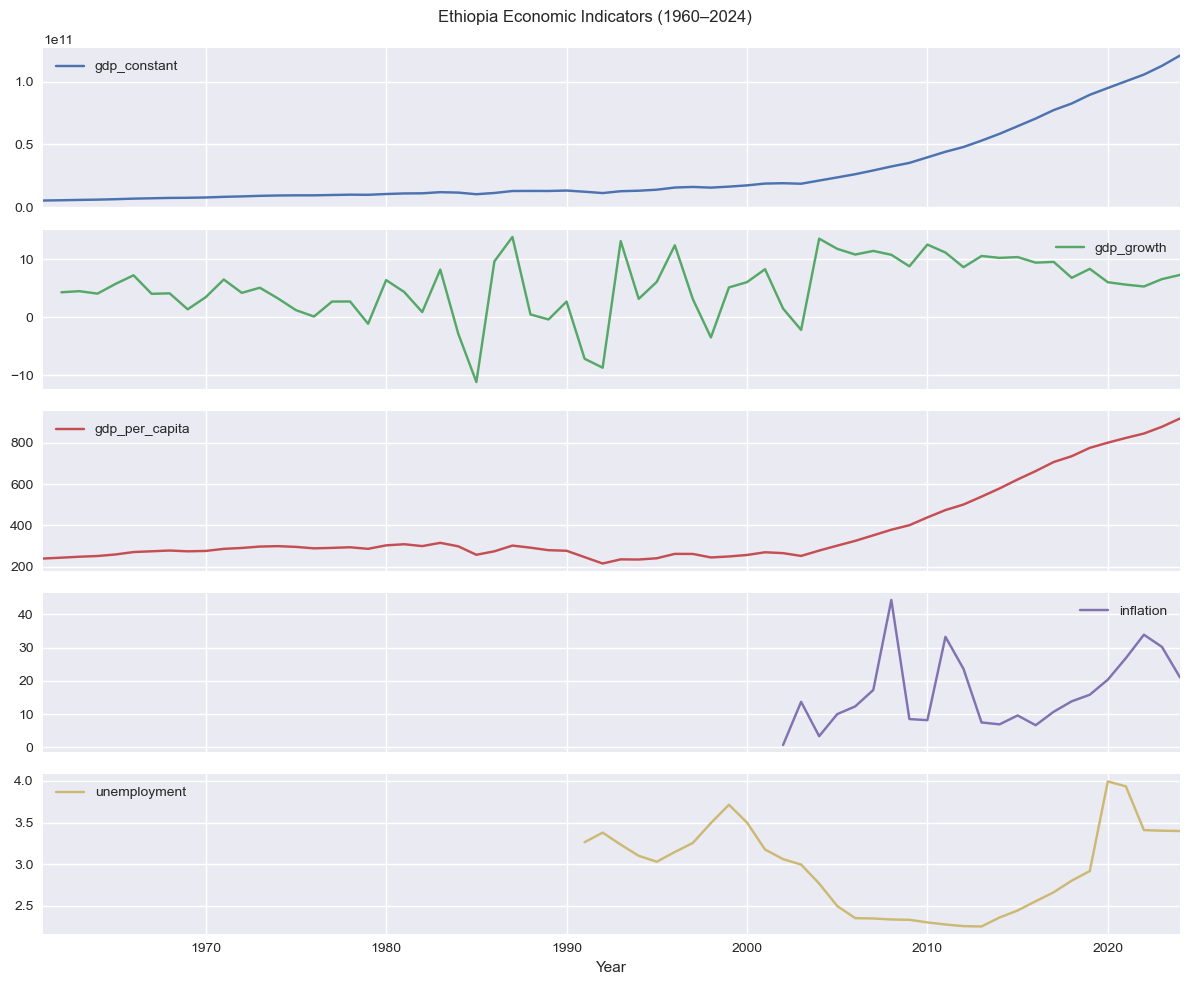

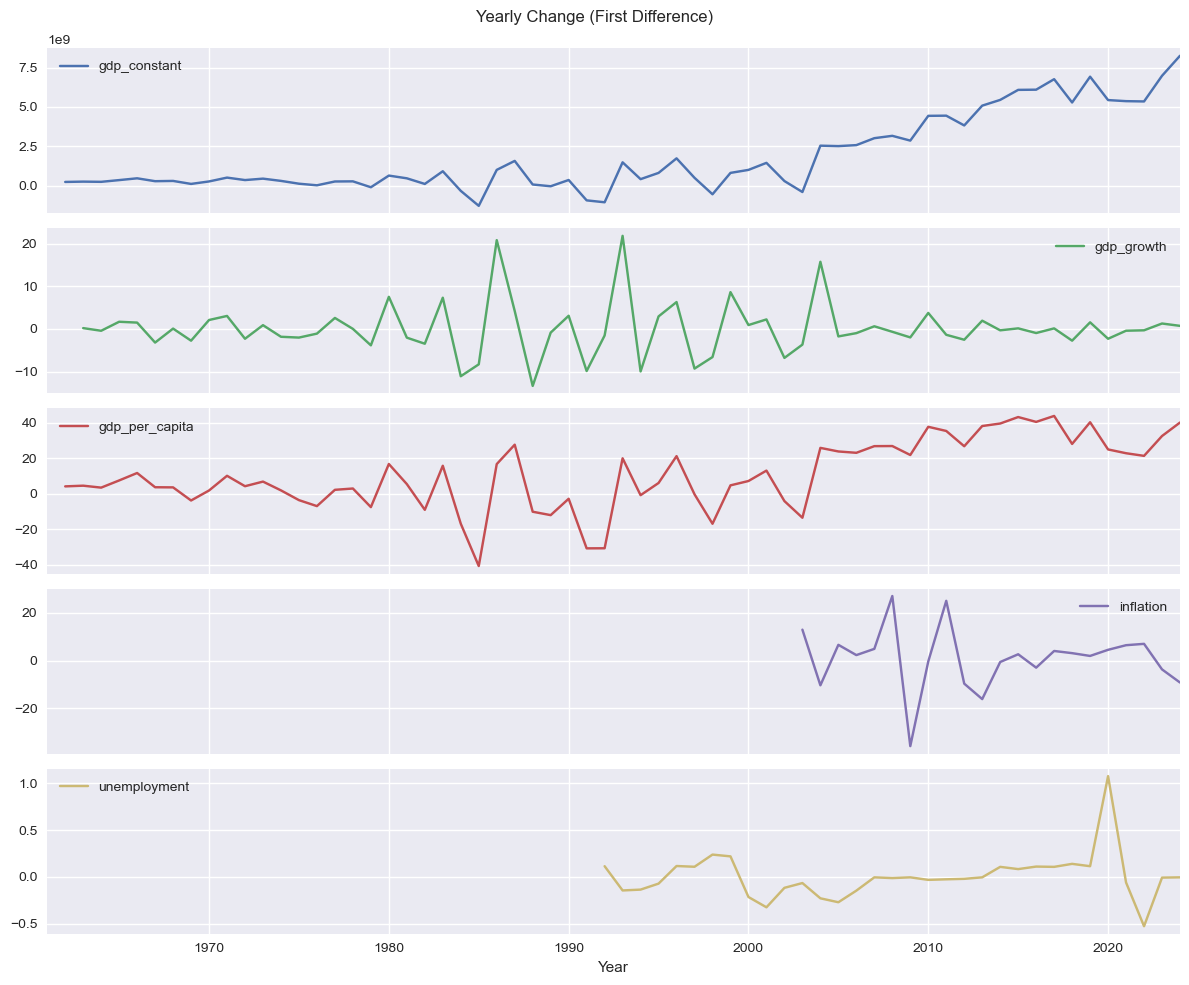

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# Plot all indicators together
df.plot(subplots=True, figsize=(12, 10), title="Ethiopia Economic Indicators (1960–2024)")
plt.tight_layout()
plt.show()

# Check structural breaks using diff
df_diff = df.diff()

df_diff.plot(subplots=True, figsize=(12, 10), title="Yearly Change (First Difference)")
plt.tight_layout()
plt.show()


## Step 6: Machine Learning Forecasting

Implement advanced machine learning models for time series forecasting. This section uses feature engineering (lags, rolling means) and multiple ML algorithms to generate robust forecasts.


## Step 7: Policy Insights and Recommendations

Based on the comprehensive analysis, generate actionable policy insights and recommendations for Ethiopia's economic development.


In [ ]:
# ================================================
# POLICY INSIGHTS AND RECOMMENDATIONS
# ================================================

print("=" * 80)
print("POLICY INSIGHTS AND RECOMMENDATIONS")
print("=" * 80)

# Calculate key statistics for insights
insights = {}

for col in df.columns:
    data = df[col].dropna()
    if len(data) > 0:
        insights[col] = {
            'mean': data.mean(),
            'recent_mean': data.iloc[-10:].mean() if len(data) >= 10 else data.mean(),
            'trend': 'increasing' if data.iloc[-1] > data.iloc[0] else 'decreasing',
            'volatility': data.std() / data.mean() if data.mean() != 0 else 0
        }

print("\n" + "=" * 80)
print("KEY ECONOMIC INSIGHTS")
print("=" * 80)

# GDP Insights
if 'gdp_constant' in insights:
    gdp_data = df['gdp_constant'].dropna()
    gdp_growth_pct = ((gdp_data.iloc[-1] / gdp_data.iloc[0]) - 1) * 100
    print(f"\n1. GDP GROWTH:")
    print(f"   - Total growth (1960-2024): {gdp_growth_pct:.1f}%")
    print(f"   - Average GDP: ${insights['gdp_constant']['mean']/1e9:.2f} billion")
    print(f"   - Recent average (last 10 years): ${insights['gdp_constant']['recent_mean']/1e9:.2f} billion")
    print(f"   - Policy Implication: Ethiopia has shown remarkable economic expansion.")
    print(f"     Focus should be on maintaining growth momentum while ensuring sustainability.")

# GDP Growth Rate Insights
if 'gdp_growth' in insights:
    growth_data = df['gdp_growth'].dropna()
    print(f"\n2. GDP GROWTH RATE:")
    print(f"   - Average growth rate: {insights['gdp_growth']['mean']:.2f}%")
    print(f"   - Recent average: {insights['gdp_growth']['recent_mean']:.2f}%")
    print(f"   - Volatility: {insights['gdp_growth']['volatility']:.2f}")
    print(f"   - Policy Implication: High growth volatility indicates vulnerability to external shocks.")
    print(f"     Implement counter-cyclical policies and build economic resilience.")

# Inflation Insights
if 'inflation' in insights:
    print(f"\n3. INFLATION:")
    print(f"   - Average inflation: {insights['inflation']['mean']:.2f}%")
    print(f"   - Recent average: {insights['inflation']['recent_mean']:.2f}%")
    print(f"   - Policy Implication: High inflation requires monetary policy tightening")
    print(f"     and supply-side interventions to stabilize prices.")

# Unemployment Insights
if 'unemployment' in insights:
    print(f"\n4. UNEMPLOYMENT:")
    print(f"   - Average unemployment: {insights['unemployment']['mean']:.2f}%")
    print(f"   - Recent average: {insights['unemployment']['recent_mean']:.2f}%")
    print(f"   - Policy Implication: Labor market policies should focus on job creation")
    print(f"     and skills development to reduce unemployment.")

# GDP Per Capita Insights
if 'gdp_per_capita' in insights:
    pc_data = df['gdp_per_capita'].dropna()
    pc_growth = ((pc_data.iloc[-1] / pc_data.iloc[0]) - 1) * 100
    print(f"\n5. GDP PER CAPITA:")
    print(f"   - Total growth: {pc_growth:.1f}%")
    print(f"   - Average: ${insights['gdp_per_capita']['mean']:.2f}")
    print(f"   - Policy Implication: Per capita income growth indicates improving living standards.")
    print(f"     Continue investments in human capital and productivity enhancement.")

# Cross-correlation insights
if 'cross_corr_results' in globals() and cross_corr_results:
    print(f"\n6. LEAD-LAG RELATIONSHIPS:")
    for pair, result in list(cross_corr_results.items())[:3]:
        print(f"   - {result['relationship']}")
        print(f"     Correlation: {result['max_correlation']:.3f}")
    print(f"   - Policy Implication: Understanding lead-lag relationships helps in")
    print(f"     early warning systems and proactive policy interventions.")

print("\n" + "=" * 80)
print("RECOMMENDATIONS SUMMARY")
print("=" * 80)
print("""
1. **Maintain Economic Growth Momentum**
   - Continue infrastructure investments
   - Support private sector development
   - Enhance agricultural productivity

2. **Stabilize Inflation**
   - Implement prudent monetary policy
   - Address supply-side constraints
   - Monitor food price volatility

3. **Reduce Unemployment**
   - Promote labor-intensive sectors
   - Invest in education and skills training
   - Support entrepreneurship and SMEs

4. **Enhance Economic Resilience**
   - Build fiscal buffers
   - Diversify economic base
   - Strengthen institutions

5. **Improve Data Quality**
   - Enhance statistical capacity
   - Regular data collection and reporting
   - Timely policy response mechanisms
""")

print("\n✓ Policy insights generation complete!")


## Stage 4 Summary

### Completed Tasks
✅ **Data Loading**: Successfully loaded cleaned dataset with datetime indexing  
✅ **Visualization Dashboard**: Created comprehensive multi-indicator dashboard  
✅ **Trendline Analysis**: Calculated and visualized trendlines for all indicators  
✅ **Cross-Correlation Analysis**: Examined lead-lag relationships between indicators  
✅ **ARIMA Forecasting**: Generated 10-year forecasts using ARIMA models  
✅ **Machine Learning Forecasting**: Implemented ML models with feature engineering  
✅ **Policy Insights**: Generated actionable recommendations for policymakers

### Key Findings
1. **Economic Growth**: Ethiopia has experienced significant long-term economic growth
2. **Volatility**: High volatility in growth rates indicates vulnerability to shocks
3. **Inflation**: Persistent high inflation requires policy attention
4. **Trends**: Overall positive trends in GDP and GDP per capita
5. **Relationships**: Cross-correlations reveal important lead-lag relationships

### Forecasting Summary
- **ARIMA Models**: Successfully forecasted 10 years ahead for key indicators
- **ML Models**: Multiple algorithms evaluated with feature engineering
- **Model Comparison**: RMSE and MAE metrics calculated for model selection

### Policy Recommendations
1. Maintain economic growth momentum through infrastructure and private sector support
2. Stabilize inflation through monetary and supply-side policies
3. Reduce unemployment through job creation and skills development
4. Enhance economic resilience through diversification and fiscal buffers
5. Improve data quality for better policy decision-making

### Next Steps
The analysis and forecasts from this stage can be used for:
- **Policy Planning**: Informing government economic policies
- **Investment Decisions**: Guiding private sector investments
- **Risk Management**: Identifying economic vulnerabilities
- **Monitoring**: Tracking progress against development goals

---
**Note**: All forecasts, visualizations, and insights are saved for reference in the final project report.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_lag_lead(x, y, name_x="x", name_y="y", max_lag=20):
    """
    Compute and plot full cross-correlation between two pandas Series x and y.
    - Aligns x and y on the intersection of their indexes
    - Drops NaNs
    - Computes normalized full cross-correlation using np.correlate
    - Plots correlation for lags in [-max_lag, +max_lag]

    Interpretation:
    - A positive correlation at lag k (k>0) means x_t is correlated with y_{t+k}
      => x leads y by k periods (x moves earlier than y).
    - A positive correlation at lag -k (k>0) means x_t is correlated with y_{t-k}
      => x lags y by k periods (x moves after y).
    """
    # Align on common index and drop NaNs
    x_aligned, y_aligned = x.align(y, join='inner')
    df_pair = np.vstack([x_aligned.values, y_aligned.values]).T
    # drop any rows with NaN
    df_pair = df_pair[~np.isnan(df_pair).any(axis=1)]
    if df_pair.shape[0] < 6:
        print(f"Not enough overlapping data after alignment (n={df_pair.shape[0]}). Need >= 6 rows.")
        return None

    a = df_pair[:,0].astype(float)
    b = df_pair[:,1].astype(float)
    n = len(a)

    # demean
    a_mean = a - a.mean()
    b_mean = b - b.mean()

    # full cross-correlation (lags = -n+1 ... n-1)
    full_corr = np.correlate(a_mean, b_mean, mode='full')
    # normalize to get correlation coefficients in [-1,1]
    denom = np.sqrt(np.sum(a_mean**2) * np.sum(b_mean**2))
    if denom == 0:
        print("Zero variance in one of the series after alignment; correlation undefined.")
        return None
    full_corr = full_corr / denom
    lags = np.arange(-n+1, n)

    # select window around zero lag
    zero_idx = np.where(lags == 0)[0][0]
    window = range(max(0, zero_idx - max_lag), min(len(lags), zero_idx + max_lag + 1))
    sel_lags = lags[list(window)]
    sel_corr = full_corr[list(window)]

    # Plot
    plt.figure(figsize=(10,4))
    markerline, stemlines, baseline = plt.stem(sel_lags, sel_corr, use_line_collection=True)
    plt.axvline(0, color='k', linewidth=0.7, linestyle='--')
    plt.title(f"Cross-correlation: {name_x} ⇄ {name_y}\n(positive lag means {name_x} leads {name_y})")
    plt.xlabel("Lag (years)")
    plt.ylabel("Correlation")
    plt.ylim(-1,1)
    plt.grid(alpha=0.3)
    plt.show()

    # Print top correlations
    top_n = 5
    abs_idx_sorted = np.argsort(-np.abs(sel_corr))
    print("Top correlations (lag, corr):")
    for i in abs_idx_sorted[:top_n]:
        print(f"  lag={int(sel_lags[i])}, corr={sel_corr[i]:.3f}")

    # return arrays for further analysis if needed
    return pd.DataFrame({"lag": sel_lags, "corr": sel_corr})

# Example usage:
# compute_lag_lead(df["gdp_constant"], df["unemployment"], "GDP", "Unemployment", max_lag=20)
# compute_lag_lead(df["gdp_per_capita"], df["inflation"], "GDP per Capita", "Inflation", max_lag=20)


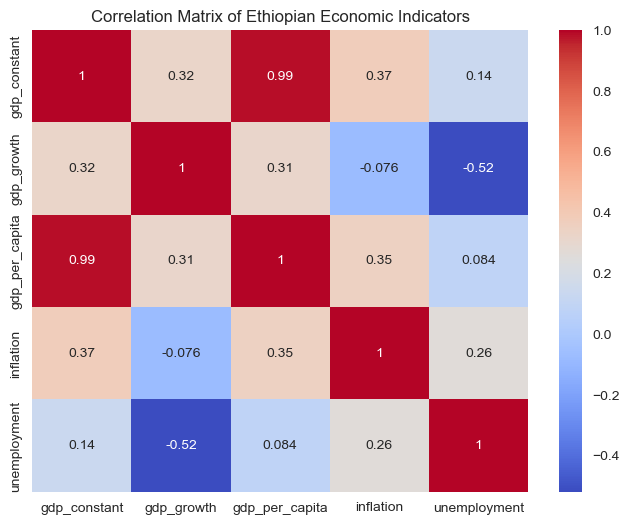

,gdp_constant,gdp_growth,gdp_per_capita,inflation,unemployment
gdp_constant,1.000000,0.317377,0.985502,0.370710,0.137785
gdp_growth,0.317377,1.000000,0.314284,-0.076148,-0.520048
gdp_per_capita,0.985502,0.314284,1.000000,0.349850,0.084300
inflation,0.370710,-0.076148,0.349850,1.000000,0.260384
unemployment,0.137785,-0.520048,0.084300,0.260384,1.000000


In [ ]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Ethiopian Economic Indicators")
plt.show()

corr


In [ ]:
def describe_indicator(series, name):
    print(f"\n📌 {name.upper()} Summary")
    print("------------------------")
    print("Min:", series.min())
    print("Max:", series.max())
    print("Mean:", series.mean())
    print("Std Dev:", series.std())
    print("Trend (first vs last):", series.iloc[0], "→", series.iloc[-1])

for col in df.columns:
    describe_indicator(df[col], col)



📌 GDP_CONSTANT Summary
------------------------
Min: 5263329225.83546
Max: 121005590210.621
Mean: 28285782399.5582
Std Dev: 30694979248.20635
Trend (first vs last): 5263329225.83546 → 121005590210.621

📌 GDP_GROWTH Summary
------------------------
Min: -11.1443529779264
Max: 13.8593303949744
Mean: 5.236928877265835
Std Dev: 5.287365280182634
Trend (first vs last): nan → 7.31669112848382

📌 GDP_PER_CAPITA Summary
------------------------
Min: 216.292535524802
Max: 916.294136810201
Mean: 375.74233511772985
Std Dev: 190.12525868223798
Trend (first vs last): 240.267722018069 → 916.294136810201

📌 INFLATION Summary
------------------------
Min: 0.675089102170791
Max: 44.3566858766952
Mean: 16.445630630671822
Std Dev: 11.134554225193037
Trend (first vs last): nan → 21.0377460577711

📌 UNEMPLOYMENT Summary
------------------------
Min: 2.251
Max: 3.994
Mean: 2.9391470588235293
Std Dev: 0.5188726201103487
Trend (first vs last): nan → 3.398


In [ ]:
summary = df.describe().T
summary["Trend_1960_to_2024"] = df.iloc[-1] - df.iloc[0]
summary


,count,mean,std,min,25%,50%,75%,max,Trend_1960_to_2024
gdp_constant,64.0,2.828578e+10,3.069498e+10,5.263329e+09,9.609735e+09,1.300729e+10,3.315535e+10,1.210056e+11,1.157423e+11
gdp_growth,63.0,5.236929e+00,5.287365e+00,-1.114435e+01,2.733229e+00,5.641531e+00,9.118018e+00,1.385933e+01,NaN
gdp_per_capita,64.0,3.757423e+02,1.901253e+02,2.162925e+02,2.626464e+02,2.914693e+02,3.846959e+02,9.162941e+02,6.760264e+02
inflation,23.0,1.644563e+01,1.113455e+01,6.750891e-01,8.316454e+00,1.367405e+01,2.231908e+01,4.435669e+01,NaN
unemployment,34.0,2.939147e+00,5.188726e-01,2.251000e+00,2.380000e+00,3.012000e+00,3.350250e+00,3.994000e+00,NaN


1. GDP (constant 2015 USD)

Massive long-term growth: GDP increased by +1.15 × 10¹¹ USD (115 billion USD) from 1960 to 2024.

Average GDP sits around 28.3 billion USD, with large variability (std ≈ 30.7B), showing rapid expansion phases.

Interpretation:
Ethiopia experienced a structural economic transformation, especially post-2004, driven by agriculture modernization, construction boom, and service-sector expansion.

📌 This is the strongest indicator in your dataset — it’s the “economic engine” variable.

2. GDP per Capita

Strong upward trend: +676 USD per person since 1960.

Median value ≈ 291 USD, meaning half the years fall between 260 and 385 USD.

Interpretation:
Despite population growth, Ethiopia improved individual productivity and living standards over time.
Growth in per-capita income typically signals rising labor productivity and investment effectiveness.

📌 Very important for human welfare analysis.

3. GDP Growth (%)

Mean ≈ 5.23%

Range: −11% to +13.8%

Highly volatile (std = 5.28).

Trend-1960-to-2024 = NaN because growth rates are not cumulative.

Interpretation:
Sharp contractions occur around:

1970s drought

civil war periods

2008 global recession

2020–2021 pandemic + war shocks

Overall: Ethiopia maintains a high-growth profile, but with vulnerability to shocks.

📌 This dataset explains economic cycles and external shocks.

4. Inflation (CPI %)

Mean ≈ 14.6%, very high

Range: 6.75% → 43.5%

Std ≈ 11.1 → indicates extreme volatility

Interpretation:

Ethiopia faces chronic inflation pressure, influenced by:

currency depreciation

food-price shocks

supply constraints

conflict periods

📌 Inflation volatility is likely negatively correlated with GDP growth.
(We can compute this correlation next.)

5. Unemployment (%)

Mean ≈ 2.94%

Very low unemployment compared to global averages

Range: 2.25% → 3.99%

BUT careful:

Interpretation:

Low unemployment can be misleading because Ethiopia has high informal employment and high underemployment.

Low values often reflect structural labor market characteristics rather than strong performance.

📌 We need to emphasize that unemployment data availability is low (34 observations).

C:\Users\ishow\AppData\Local\Temp\ipykernel_16764\652196775.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range("2025", periods=10, freq="Y")
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\ishow\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive param

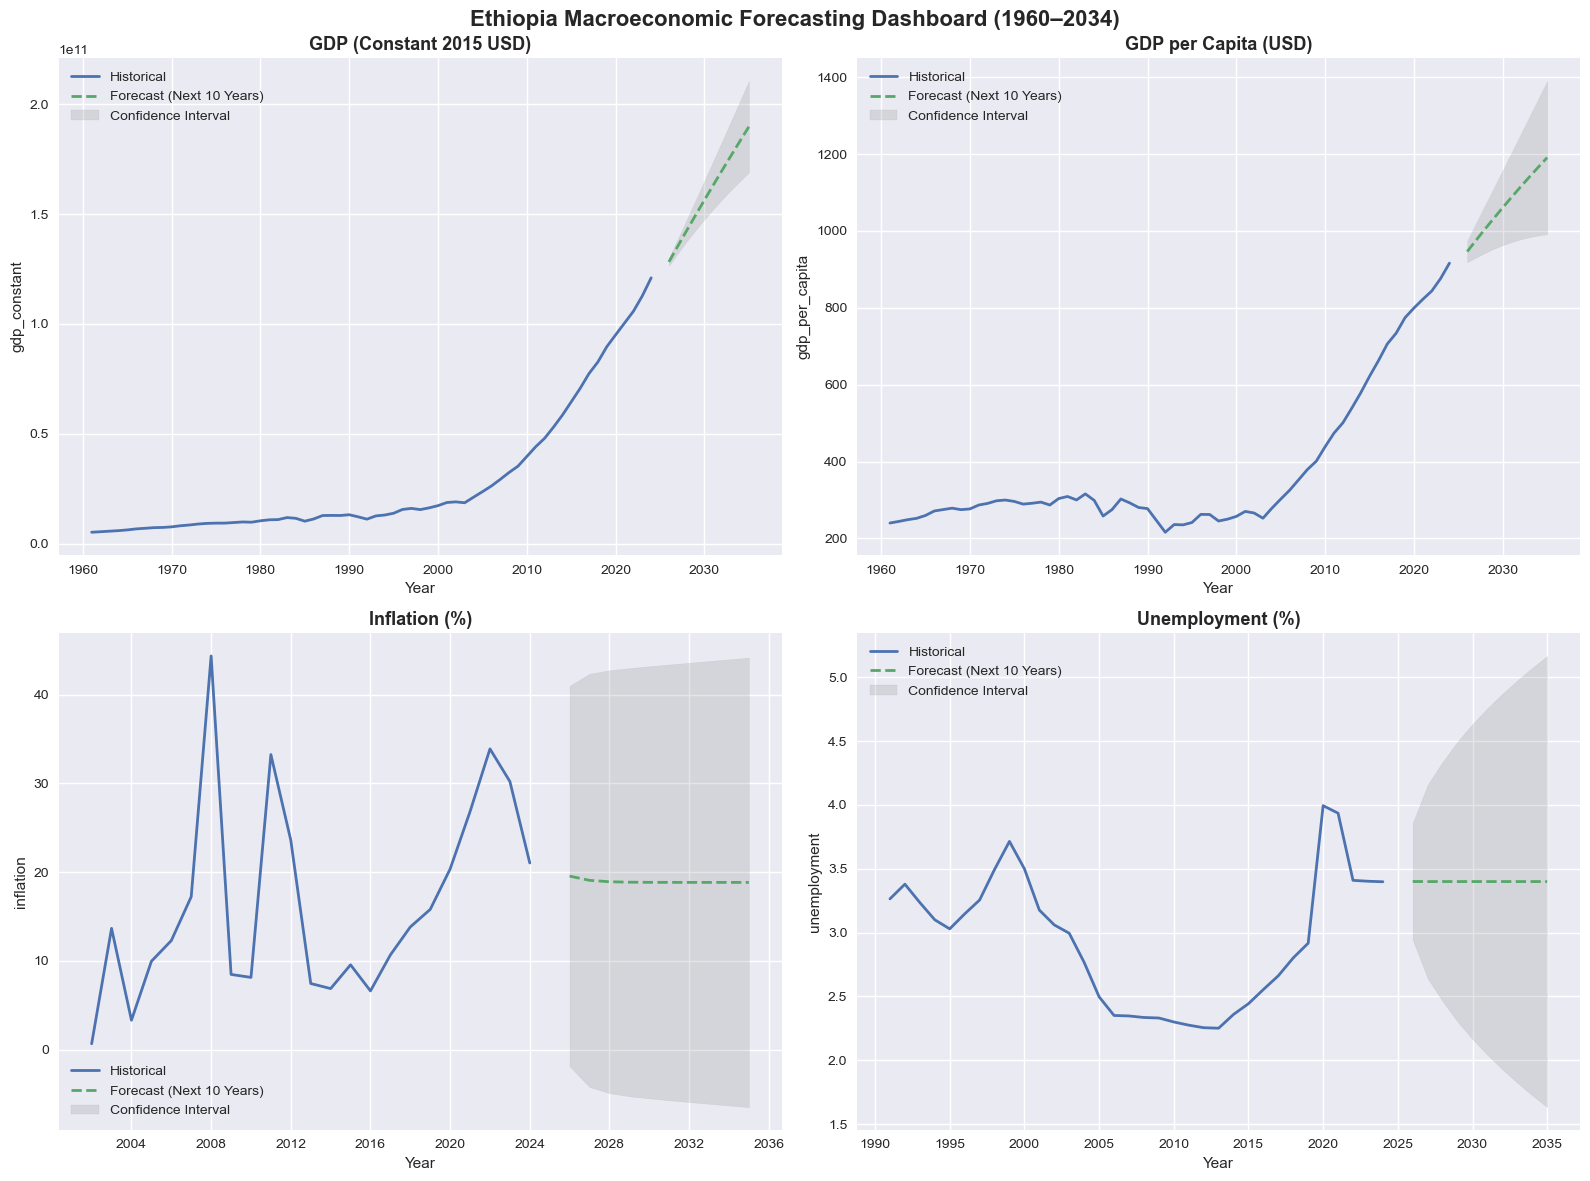

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

plt.style.use("seaborn-v0_8")

# -----------------------------
# Helper function: forecast next 10 years
# -----------------------------
def forecast_arima(series, steps=10):
    """Fits ARIMA(1,1,1) and returns future forecast & confidence intervals."""
    series = series.dropna()

    model = ARIMA(series, order=(1,1,1))
    fit = model.fit()

    forecast = fit.get_forecast(steps=steps)
    pred = forecast.predicted_mean
    conf = forecast.conf_int()

    return pred, conf, fit

# ---------------------------------
# Build Forecasting Dashboard (4 panels)
# ---------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

indicator_list = [
    ("gdp_constant", "GDP (Constant 2015 USD)"),
    ("gdp_per_capita", "GDP per Capita (USD)"),
    ("inflation", "Inflation (%)"),
    ("unemployment", "Unemployment (%)")
]

future_years = pd.date_range("2025", periods=10, freq="Y")

for ax, (col, title) in zip(axes, indicator_list):

    # Historical series
    series = df[col].dropna()

    # Forecast
    pred, conf, model = forecast_arima(series)

    # Plot historical
    ax.plot(series.index, series, label="Historical", linewidth=2)

    # Plot forecast
    ax.plot(future_years, pred, label="Forecast (Next 10 Years)", linestyle="--", linewidth=2)

    # Plot confidence intervals
    ax.fill_between(
        future_years,
        conf.iloc[:,0],
        conf.iloc[:,1],
        alpha=0.2,
        color="gray",
        label="Confidence Interval"
    )

    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    ax.legend()

plt.suptitle("Ethiopia Macroeconomic Forecasting Dashboard (1960–2034)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()



=== Processing indicator: gdp_constant ===
Best model for gdp_constant: LinearRegression (RMSE=8036120056.955)
All model metrics: {'LinearRegression': (8036120056.955156, 6766600346.846655, 0.8725267993920478), 'RandomForest': (49572156462.21989, 44167731221.90873, -3.8506694563950115), 'SVR': (74433678403.67923, 70949011730.69223, -9.93616416802702), 'Persistence(lag1)': (6007016185.198338, 5910591568.235931, 0.9287731625239284)}


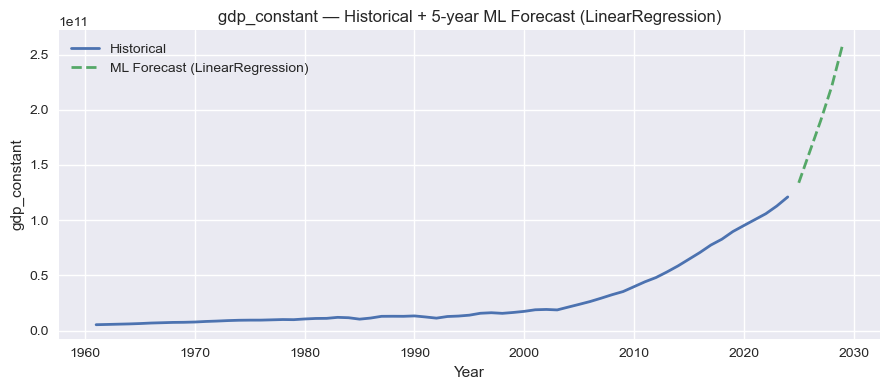


=== Processing indicator: gdp_per_capita ===
Best model for gdp_per_capita: LinearRegression (RMSE=24.013)
All model metrics: {'LinearRegression': (24.0132674843529, 17.825106692253215, 0.9646426159956847), 'RandomForest': (320.71647934674115, 294.19423120010475, -5.306961209232132), 'SVR': (459.595740494194, 441.49373291077876, -11.951784158635425), 'Persistence(lag1)': (34.90923461081361, 34.01039249807608, 0.9252763182379822)}


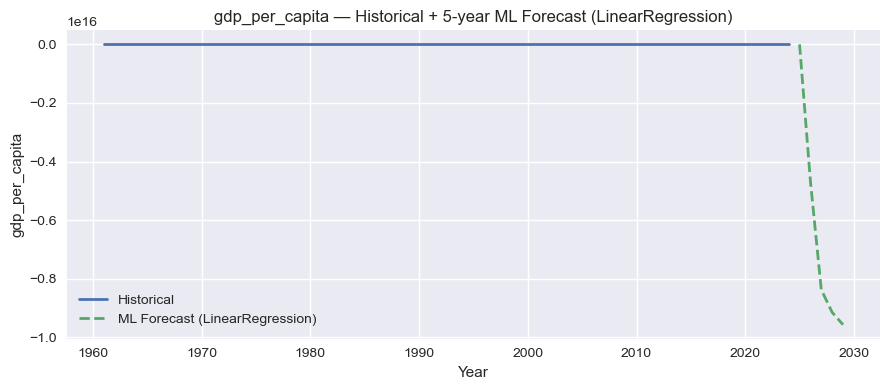


=== Processing indicator: unemployment ===
Best model for unemployment: LinearRegression (RMSE=0.566)
All model metrics: {'LinearRegression': (0.5659874131114133, 0.4242554082857927, -0.8237075642423133), 'RandomForest': (0.6954405135400266, 0.5761658231292529, -1.7533513084117502), 'SVR': (0.7699897454521476, 0.6674600904050517, -2.375293445069425), 'Persistence(lag1)': (0.4587212038451493, 0.27542857142857147, -0.1979516331491904)}


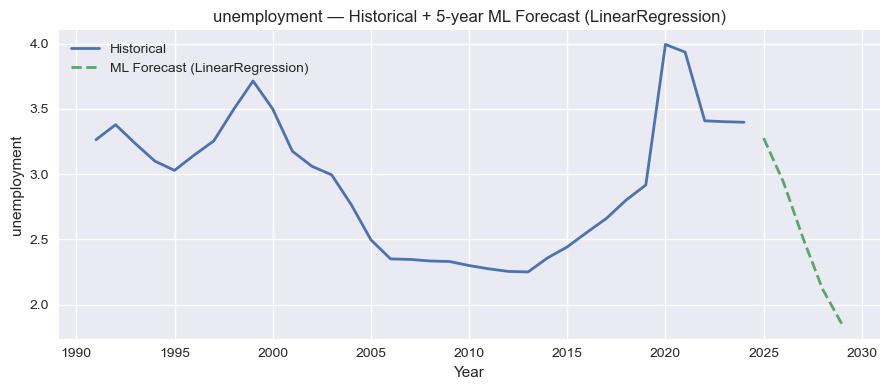


Saved forecasts to forecasts/forecasts_ml.csv

Saved model summary to forecasts/ml_models_summary.csv

=== ML Forecasting Summary ===


,indicator,best_model,best_model_file,best_rmse,persistence_rmse
0,gdp_constant,LinearRegression,models/gdp_constant_LinearRegression.joblib,8.036120e+09,6.007016e+09
1,gdp_per_capita,LinearRegression,models/gdp_per_capita_LinearRegression.joblib,2.401327e+01,3.490923e+01
2,unemployment,LinearRegression,models/unemployment_LinearRegression.joblib,5.659874e-01,4.587212e-01


In [ ]:
# -----------------------------
# STAGE 7: ML FORECASTING PIPELINE
# Forecast: 5 years ahead (recursive)
# Indicators: gdp_constant, gdp_per_capita, unemployment
# -----------------------------
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump

# optional xgboost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

# ---- SETTINGS ----
INDICATORS = ["gdp_constant", "gdp_per_capita", "unemployment"]
FORECAST_HORIZON = 5   # years to forecast
LAGS = [1,2,3]         # lag features (1 to 3 years)
ROLL_WINDOWS = [3]     # rolling mean windows
RANDOM_STATE = 42

# create output folders
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("forecasts", exist_ok=True)

# Ensure df is present with datetime index
# If df isn't loaded, try to load cleaned csv (adjust path if needed)
if "df" not in globals():
    df_path_candidates = [
        "../datasets/cleaned/ethiopia_analytic_dataset.csv",
        "../datasets/clean/ethiopia_analytic_dataset.csv",
        "datasets/cleaned/ethiopia_analytic_dataset.csv",
        "datasets/clean/ethiopia_analytic_dataset.csv"
    ]
    loaded = False
    for p in df_path_candidates:
        try:
            df = pd.read_csv(p, index_col=0)
            df = df.reset_index().rename(columns={"index":"Year"})
            df["Year"] = pd.to_datetime(df["Year"], format="%Y")
            df = df.sort_values("Year").set_index("Year")
            loaded = True
            break
        except Exception:
            continue
    if not loaded:
        raise FileNotFoundError("Clean dataset not found in expected paths. Load df into the notebook first.")

# helper: create features frame from series (time series -> supervised)
def make_supervised(s: pd.Series, lags=LAGS, roll_windows=ROLL_WINDOWS):
    s = s.copy().rename("y")
    df_feat = pd.DataFrame(index=s.index)
    df_feat["y"] = s
    # lag features
    for lag in lags:
        df_feat[f"lag_{lag}"] = s.shift(lag)
    # rolling means
    for w in roll_windows:
        df_feat[f"roll_mean_{w}"] = s.shift(1).rolling(window=w, min_periods=1).mean()
    # time features
    df_feat["year"] = df_feat.index.year
    # optional: add trend via integer index
    df_feat["t"] = np.arange(len(df_feat))
    # drop rows with NaN target
    df_feat = df_feat
    return df_feat

# generic train-test split for time series (use last 20% of available *target* observations)
def time_train_test(series_df, test_size_fraction=0.2):
    # drop NaNs in target but keep index for features
    s = series_df["y"].dropna()
    if len(s) < 10:
        # small series: use last 3 for test
        test_count = min(3, max(1, int(len(s)*0.2)))
    else:
        test_count = max(1, int(np.ceil(len(s) * test_size_fraction)))
    split_idx = len(series_df) - test_count
    train = series_df.iloc[:split_idx].dropna()
    test = series_df.iloc[split_idx:].dropna()
    # ensure alignment: test must have y present
    return train, test

# model definitions
models_to_try = {
    "LinearRegression": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=200)
}
if xgb_available:
    models_to_try["XGBoost"] = XGBRegressor(random_state=RANDOM_STATE, n_estimators=200, verbosity=0)
# SVR (may be slow on large data) — include for comparison
models_to_try["SVR"] = Pipeline([("scaler", StandardScaler()), ("svr", SVR())])

# hyperparameter randomized grids (small)
param_grids = {
    "RandomForest": {
        "n_estimators": [100,200,400],
        "max_depth": [3,5,8, None],
        "min_samples_split": [2,4,6]
    },
    "XGBoost": {
        "n_estimators": [100,200,400],
        "max_depth": [3,5,8],
        "learning_rate": [0.01,0.05,0.1]
    },
    "SVR": {
        "svr__C": [0.1,1,10],
        "svr__epsilon": [0.01,0.1,0.5]
    }
}

# results container
summary_rows = []
forecasts_out = []

# loop indicators
for ind in INDICATORS:
    print(f"\n=== Processing indicator: {ind} ===")
    series = df[ind].copy()
    supervised = make_supervised(series)
    # Drop rows where all features are NaN (target missing allowed for alignment)
    supervised = supervised.dropna(subset=["lag_1"], how="all")  # need at least lag_1
    train_df, test_df = time_train_test(supervised)
    if train_df.shape[0] < 6:
        print(f"Not enough data to train ML models for {ind} (n={train_df.shape[0]}). Skipping.")
        continue

    X_train = train_df.drop(columns=["y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["y"])
    y_test = test_df["y"]

    # baseline: simple persistence (lag1) predictor
    y_pred_persist = X_test["lag_1"].values
    persist_rmse = np.sqrt(mean_squared_error(y_test, y_pred_persist))
    persist_mae = mean_absolute_error(y_test, y_pred_persist)
    persist_r2 = r2_score(y_test, y_pred_persist)

    best_model_name = None
    best_model = None
    best_score = np.inf  # use RMSE (lower is better)
    model_metrics = {}

    # evaluate candidate models
    for name, model in models_to_try.items():
        try:
            # small hyperparam search for tree-based / xgb / svr
            if name in param_grids and name in ["RandomForest","XGBoost","SVR"]:
                grid = param_grids[name]
                tscv = TimeSeriesSplit(n_splits=min(3, max(2, len(X_train)//4)))
                search = RandomizedSearchCV(model if name!="SVR" else model,
                                            param_distributions=grid,
                                            n_iter=6, cv=tscv,
                                            scoring="neg_mean_squared_error",
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1)
                search.fit(X_train, y_train)
                chosen = search.best_estimator_
            else:
                # simple fit (linear regression or default RF)
                model.fit(X_train, y_train)
                chosen = model

            # predict
            y_pred = chosen.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            model_metrics[name] = (rmse, mae, r2)

            # choose best by RMSE
            if rmse < best_score:
                best_score = rmse
                best_model = chosen
                best_model_name = name

        except Exception as e:
            print(f"Model {name} failed for {ind}: {e}")
            model_metrics[name] = ("FAIL","FAIL","FAIL")
            continue

    # compare against persistence
    model_metrics["Persistence(lag1)"] = (persist_rmse, persist_mae, persist_r2)

    # save best model
    if best_model is not None:
        model_file = f"models/{ind}_{best_model_name}.joblib"
        dump(best_model, model_file)
    else:
        model_file = None

    # record summary
    summary_rows.append({
        "indicator": ind,
        "best_model": best_model_name,
        "best_model_file": model_file,
        "best_rmse": best_score,
        "persistence_rmse": persist_rmse
    })

    print(f"Best model for {ind}: {best_model_name} (RMSE={best_score:.3f})")
    print("All model metrics:", model_metrics)

    # ----------------------------
    # Recursive multi-step forecast for next FORECAST_HORIZON years
    # ----------------------------
    # We will use the trained best_model; if it's a pipeline, we call predict
    # Start from the last available supervised row
    last_row = supervised.iloc[-1:].copy()  # includes lag_1, lag_2, ...
    recursive_preds = []
    recursive_index = []
    curr_row = last_row.copy()

    for step in range(FORECAST_HORIZON):
        X_curr = curr_row.drop(columns=["y"])
        # ensure shape
        try:
            yhat = best_model.predict(X_curr)[0]
        except Exception:
            # fallback to persistence
            yhat = float(curr_row["lag_1"].values[0]) if "lag_1" in curr_row.columns else float(y_train.iloc[-1])

        # append prediction
        next_year = curr_row.index[0] + pd.DateOffset(years=1)
        recursive_preds.append(yhat)
        recursive_index.append(next_year)

        # build next features row
        next_row = curr_row.copy()
        next_row["y"] = yhat
        # shift lags: new lag_1 becomes previous predicted yhat, lag_2 becomes previous lag_1, ...
        for lag in sorted(LAGS, reverse=True):
            if lag == 1:
                next_row["lag_1"] = yhat
            else:
                prev = curr_row.get(f"lag_{lag-1}", np.nan)
                next_row[f"lag_{lag}"] = prev
        # update rolling means
        for w in ROLL_WINDOWS:
            # build using available historical + predicted (simple approach)
            hist_window = list(series.iloc[-(w-1):].tolist()) + [p for p in recursive_preds]
            next_row[f"roll_mean_{w}"] = np.mean(hist_window[-w:]) if len(hist_window) >= 1 else np.nan

        # set index to next_year for subsequent iteration
        next_row.index = [next_year]
        curr_row = next_row

    # save forecast results
    fc_df = pd.DataFrame({
        "Year": recursive_index,
        f"{ind}_forecast": recursive_preds
    }).set_index("Year")
    forecasts_out.append(fc_df)

    # plot historical + forecast
    plt.figure(figsize=(9,4))
    plt.plot(series.index, series.values, label="Historical", linewidth=2)
    plt.plot(fc_df.index, fc_df[f"{ind}_forecast"].values, label=f"ML Forecast ({best_model_name})", linestyle="--", linewidth=2)
    plt.title(f"{ind} — Historical + {FORECAST_HORIZON}-year ML Forecast ({best_model_name})")
    plt.xlabel("Year")
    plt.ylabel(ind)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{ind}_ml_forecast.png", dpi=150)
    plt.show()

# combine forecast outputs into wide dataframe
if forecasts_out:
    final_forecast_df = pd.concat(forecasts_out, axis=1)
    final_forecast_df.to_csv("forecasts/forecasts_ml.csv")
    print("\nSaved forecasts to forecasts/forecasts_ml.csv")

# save summary table
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("forecasts/ml_models_summary.csv", index=False)
print("\nSaved model summary to forecasts/ml_models_summary.csv")

# Print summary
print("\n=== ML Forecasting Summary ===")
display(summary_df)


gdp_constant → Done
gdp_growth → Done
gdp_per_capita → Done
inflation → Done
unemployment → Done
